<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/PyMC_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from scipy.stats import norm, bernoulli, uniform, binom
import pymc as pm
from sklearn.linear_model import LogisticRegression

In [ ]:
def simulate_data():
    np.random.seed(0)
    n = 300
    X = np.random.uniform(-5, 5, n)
    beta_0, beta_1, beta_2 = 1, 3, 0
    logit_p = beta_0 + beta_1 * X + beta_2 * X**2
    p = 1 / (1 + np.exp(-logit_p))
    Y = np.random.binomial(1, p)
    return pd.DataFrame({'X': X, 'X2': X**2, 'Y': Y})

In [ ]:
simulate_data()

,X,X2,Y
0,0.488135,0.238276,1
1,2.151894,4.630646,1
2,1.027634,1.056031,1
3,0.448832,0.201450,1
4,-0.763452,0.582859,0
...,...,...,...
295,-2.756830,7.600110,0
296,-4.021555,16.172906,0
297,3.621915,13.118270,1
298,4.729195,22.365284,1


In [ ]:
# Function Definitions
def invlogit(x):
    return 1.0 / (1 + np.exp(-x))

In [ ]:
def fit_frequentist_logistic_regression(data):
    model = LogisticRegression(solver='liblinear')
    model.fit(data[['X', 'X2']], data['Y'])
    return model

In [ ]:
# Simulate Data
data = simulate_data()

# Frequentist Logistic Regression
frequentist_model = fit_frequentist_logistic_regression(data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


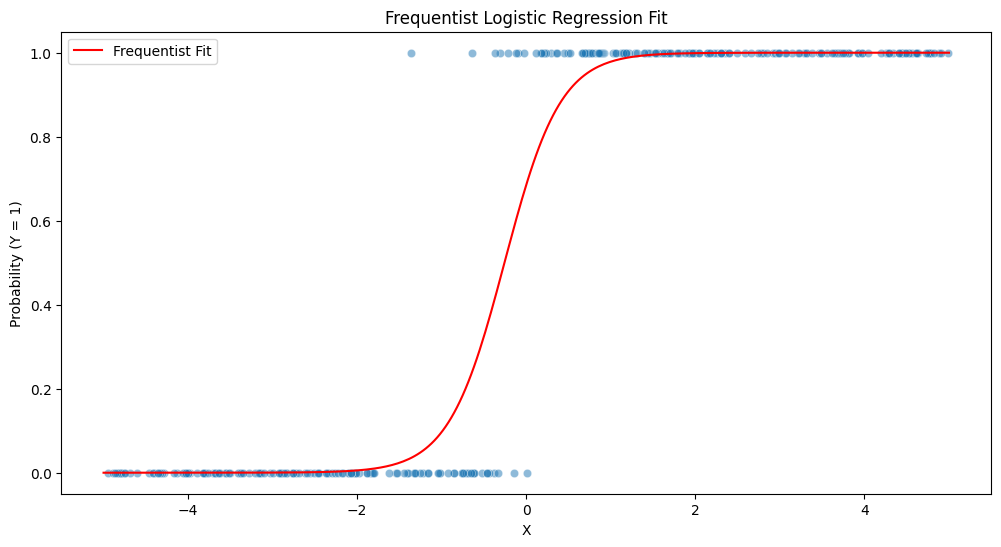

In [ ]:
# Plotting Results
plt.figure(figsize=(12, 6))

# Frequentist Results
sns.scatterplot(x='X', y='Y', data=data, alpha=0.5)
x_values = np.linspace(-5, 5, 300)
y_values = frequentist_model.predict_proba(np.column_stack((x_values, x_values**2)))[:, 1]
plt.plot(x_values, y_values, color='red', label='Frequentist Fit')
plt.xlabel('X')
plt.ylabel('Probability (Y = 1)')
plt.title('Frequentist Logistic Regression Fit')
plt.legend()
plt.show()

In [ ]:
# Bayesian Logistic Regression
with pm.Model() as bayesmodel:
 beta0 = pm.Flat('beta0')
 beta1 = pm.Flat('beta1')
 beta2 = pm.Flat('beta2')
 p = invlogit(beta0 + beta1 * data['X'] + beta2 * data['X2'])
 y_obs = pm.Binomial('y_obs', n=np.ones(len(data['Y'])), p=p, observed=data['Y'])
 start = pm.find_MAP()
 step = pm.NUTS()
 bayesian_trace = pm.sample(draws=1000, step=step, start=start, progressbar=True)


<ipython-input-15-ef03b2e3054d>:10: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  bayesian_trace = pm.sample(draws=1000, step=step, start=start, progressbar=True)


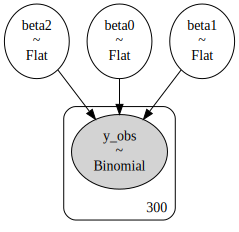

In [ ]:
pm.model_to_graphviz(bayesmodel)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 1.0, 'Bayesian Logistic Regression Coefficients')

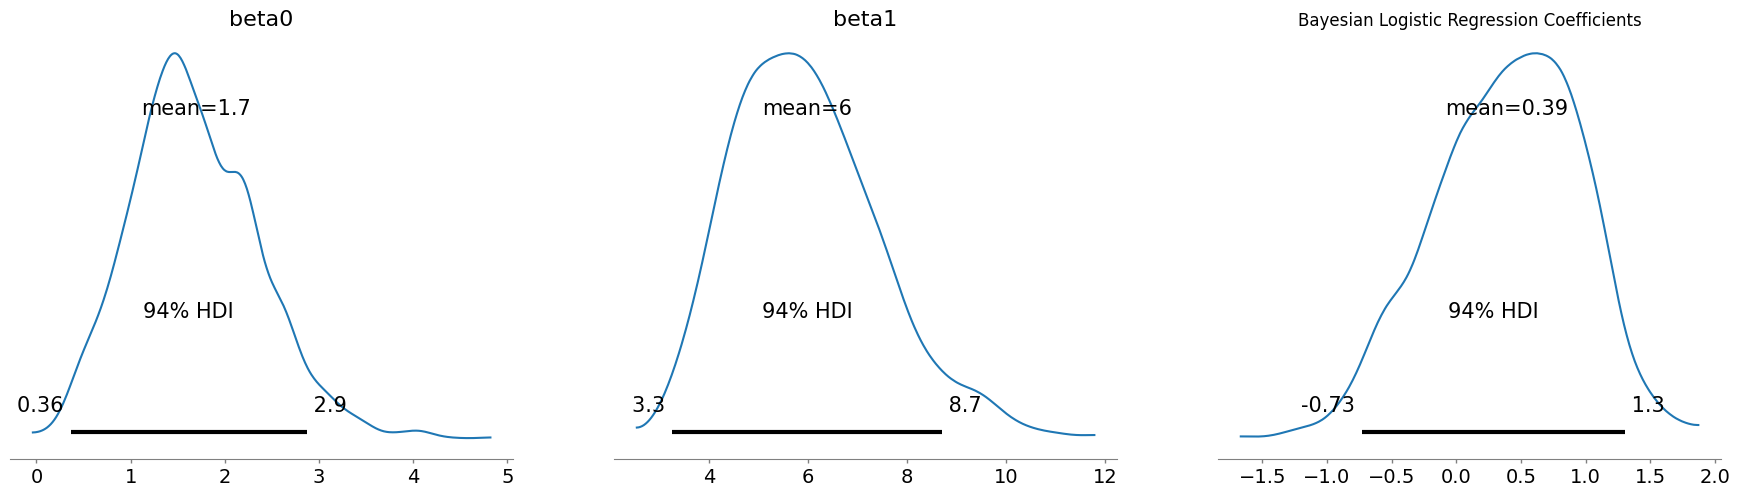

In [ ]:
pm.plot_posterior(bayesian_trace, var_names=['beta0', 'beta1', 'beta2'])
plt.title('Bayesian Logistic Regression Coefficients')

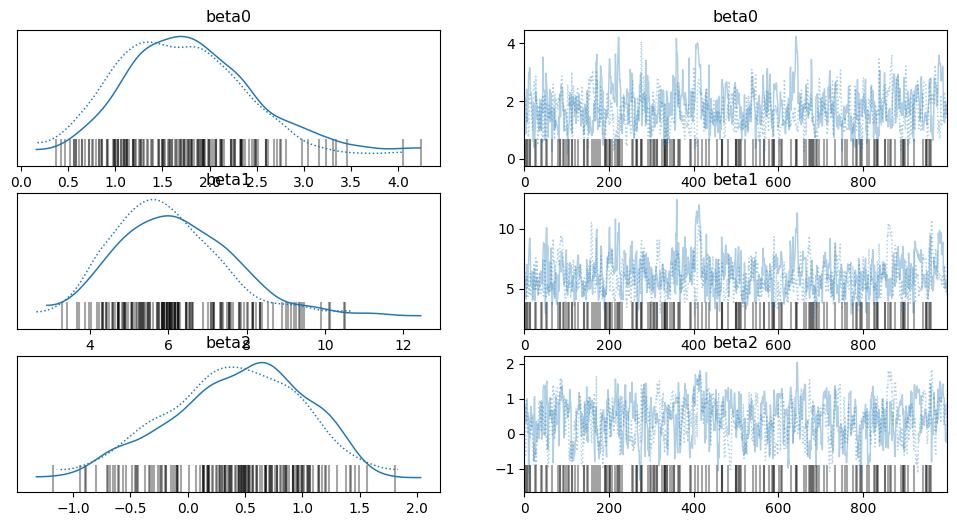

In [ ]:
# Graphical output
pm.plot_trace(bayesian_trace)
plt.show()

In [ ]:
print(bayesian_trace)
# Optionally, print a summary
pm.summary(bayesian_trace)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.690,0.691,0.363,2.870,0.034,0.025,449.0,537.0,1.01
beta1,5.971,1.500,3.253,8.712,0.079,0.058,389.0,412.0,1.01
beta2,0.388,0.566,-0.730,1.301,0.028,0.020,401.0,641.0,1.00


In [ ]:
beta0_samples = bayesian_trace.posterior['beta0'].values.flatten()
beta1_samples = bayesian_trace.posterior['beta1'].values.flatten()
beta2_samples = bayesian_trace.posterior['beta2'].values.flatten()

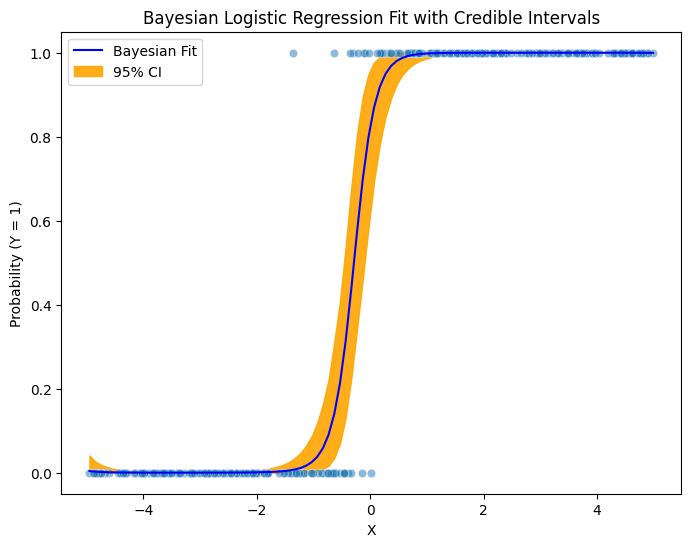

In [ ]:
    x_range = np.linspace(data['X'].min(), data['X'].max(), 100)
    x2_range = x_range**2

    # Calculate the mean and 95% credible interval for each x value
    mean_p = []
    ci_lower = []
    ci_upper = []
    for x, x2 in zip(x_range, x2_range):
        p = invlogit(beta0_samples + beta1_samples * x + beta2_samples * x2)
        mean_p.append(np.mean(p))
        ci = np.percentile(p, [2.5, 97.5])
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(x_range, mean_p, label='Bayesian Fit', color='blue')
    plt.fill_between(x_range, ci_lower, ci_upper, color='orange', alpha=0.9, label='95% CI')

    sns.scatterplot(x='X', y='Y', data=data, alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Probability (Y = 1)')
    plt.title('Bayesian Logistic Regression Fit with Credible Intervals')
    plt.legend()
    plt.show()

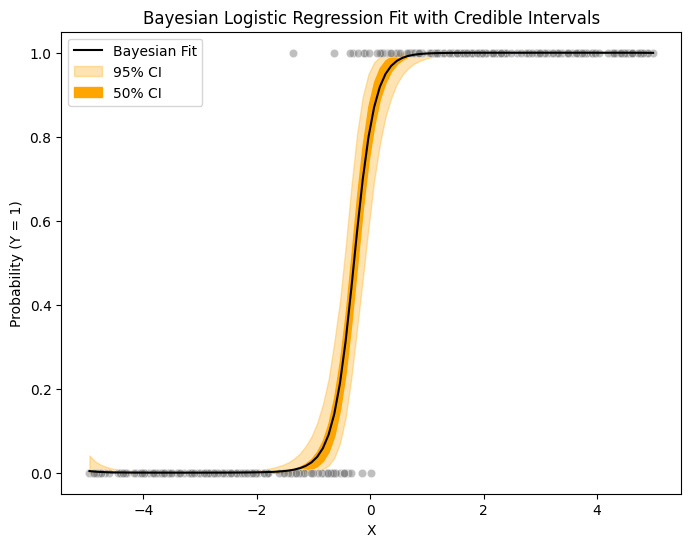

In [ ]:
# Calculate the mean, 50% CI, and 95% CI for each x value
mean_p = []
ci_50_lower = []  # Lower bound of the 50% CI
ci_50_upper = []  # Upper bound of the 50% CI
ci_95_lower = []  # Lower bound of the 95% CI
ci_95_upper = []  # Upper bound of the 95% CI

for x, x2 in zip(x_range, x2_range):
    p = invlogit(beta0_samples + beta1_samples * x + beta2_samples * x2)
    mean_p.append(np.mean(p))

    # 50% CI
    ci_50 = np.percentile(p, [25, 75])
    ci_50_lower.append(ci_50[0])
    ci_50_upper.append(ci_50[1])

    # 95% CI
    ci_95 = np.percentile(p, [2.5, 97.5])
    ci_95_lower.append(ci_95[0])
    ci_95_upper.append(ci_95[1])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_range, mean_p, label='Bayesian Fit', color='black')
plt.fill_between(x_range, ci_95_lower, ci_95_upper, color='orange', alpha=0.3, label='95% CI')
plt.fill_between(x_range, ci_50_lower, ci_50_upper, color='orange', alpha=1, label='50% CI')
sns.scatterplot(x='X', y='Y', data=data, alpha=0.5,color="gray")
plt.xlabel('X')
plt.ylabel('Probability (Y = 1)')
plt.title('Bayesian Logistic Regression Fit with Credible Intervals')
plt.legend()
plt.show()

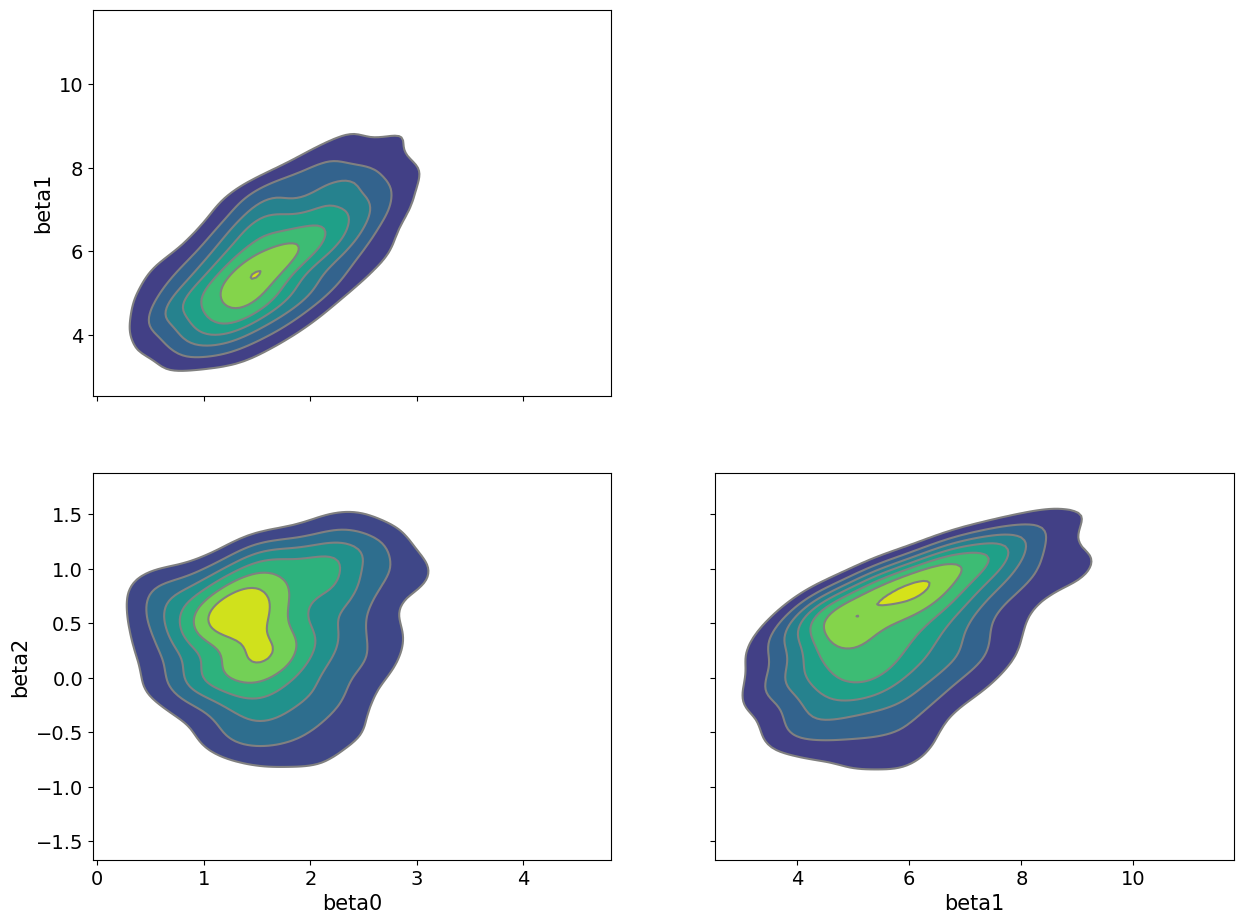

In [ ]:
az.plot_pair(bayesian_trace, var_names=['beta0', 'beta1', 'beta2'], kind='kde')
plt.show()